# calcanoms 

This is the third step in reproducing the cluster analysis following [Amini and Straus 2019] (https://doi.org/10.1007/s00382-018-4409-7)

This program:
1. Calculates the seasonal cycle for the NDJFM Z500 and U250 data
* Input File: `/glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.nc`
* or Input File: `/glade/work/mkorendy/metisregimes/era5.u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.nc`
* Seasonal cycle is calculated using David's parabola method
* Fit a parabola at each grid point over all days in the season for each year
* Average the parabola at each grid point over all years, this is the climatological seasonal cycle
2. Calculates the anomalies
* By removing the climatological seasonal cycle from the full fields
3. Writes anomalies to a single netcdf file containing both variables
* Output File: `/glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc`
* or Output File: `/glade/work/mkorendy/metisregimes/era5.u250pna_NDJFM_lpfilter_twicedaily_10days.1980-2015.anoms.nc`

### Function to calculate the climatology using the parabola fit method

In [1]:
def climo_parabola(da):
  
    nt,ny,nx=da.shape
    print(da.shape)
    ndays=272
    nyr=int(nt/ndays)   #number of years
    print(nyr)
    
    
    poly=np.zeros((nyr,ndays,ny,nx))
    x=np.arange(ndays) #days
    y=da.reshape(nyr,ndays,nx*ny) #reshape input array to have (number of years, days, grid points), new dataset

    for iyr in range(nyr):
        pfitcoeffs=np.polyfit(x,y[iyr,:,:],3)
    
        k=0
        for j in range(ny):
            for i in range(nx):
                poly[iyr,:,j,i]=np.polyval(pfitcoeffs[:,k],x)
                k+=1
    climo=poly.mean(axis=0)
    
    return climo

### Function to remove the climatology from the data to get anomalies

In [2]:
def make_anoms(da,climo):

    nt,ny,nx=da.shape
    ndays=272
    nyr=int(nt/ndays)
    y=da.reshape(nyr,ndays,ny,nx) #reshaped data set

    anoms=np.zeros((nyr,ndays,ny,nx)) #anomaly data set

    for iyr in range(nyr):
        anoms[iyr,:,:,:]=y[iyr,:,:,:]-climo 
        
    anoms=anoms.reshape(nt,ny,nx)
    
    return anoms

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
variable = 'z500'

### Define input and output files

In [5]:
# Input
path='/glade/work/mkorendy/metisregimes/'
fname='era5.' + variable + '_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.nc'

# Output
ofname='era5.' + variable + '_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc'
outfile=path+ofname
clim_out = path + 'era5.' + variable + '_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.climo.nc'

### Set the list of years

In [6]:
yrs_list=np.arange(1986,2016)

### Read the data

In [7]:
ds=xr.open_dataset(path+fname,decode_times=True)
start = pd.to_datetime('1986-11')
end = pd.to_datetime('2016-04')
ds = ds.sel(time=slice(start,end))

In [8]:
ds.time

<xarray.DataArray 'time' (time: 8160)>
array(['1986-11-08T12:00:00.000000000', '1986-11-09T00:00:00.000000000',
       '1986-11-09T12:00:00.000000000', ..., '2016-03-22T00:00:00.000000000',
       '2016-03-22T12:00:00.000000000', '2016-03-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1986-11-08T12:00:00 1986-11-09 ... 2016-03-23

In [9]:
#plt.plot(ds['low_pass_z500'][:,12,25])

In [10]:
#plt.plot(ds['u250'][0:88,12,25])

In [12]:
climo_z500=climo_parabola(ds['low_pass_' + variable].values)
#climo_u250=climo_parabola(ds['u250'].values)

(8160, 22, 53)
30


In [13]:
10608/(146*1166)

0.0623134942080406

In [16]:
anoms_z500=make_anoms(ds['low_pass_' + variable].values,climo_z500)
#anoms_u250=make_anoms(ds['low_pass_zu250'].values,climo_u250)
anoms_z500.shape

(8160, 22, 53)

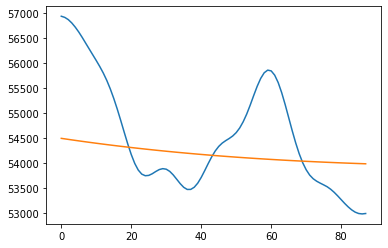

In [17]:
plt.plot(ds['low_pass_' + variable][0:88,12,25])
plt.plot(climo_z500[0:88,12,25])

In [18]:
ds_z500_anoms=xr.DataArray(anoms_z500,
                coords={'time':np.arange(len(ds['time'])),
                        'lat':ds['lat'],
                        'lon': ds['lon']},
                        dims=['time','lat','lon'])        
ds_z500_anoms=ds_z500_anoms.to_dataset(name=variable)

#ds_u250_anoms=xr.DataArray(anoms_u250,
#                coords={'time':np.arange(len(ds['time'])),
#                        'lat':ds['lat'],
#                        'lon': ds['lon']},
#                        dims=['time','lat','lon'])        
#ds_u250_anoms=ds_u250_anoms.to_dataset(name='u250')

#ds_anoms=xr.merge([ds_z500_anoms,ds_u250_anoms])

In [48]:
ds_z500_anoms

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    u250     (time, lat, lon) float64 -0.6269 0.2183 1.042 ... -3.014 -3.444

In [20]:
climo_z500.shape

(272, 22, 53)

In [24]:
ds_z500_climo = xr.DataArray(climo_z500,
                            coords={'time':np.arange(272),
                                    'lat':ds['lat'],
                                    'lon':ds['lon']},
                             dims=['time','lat','lon'])
ds_z500_climo = ds_z500_climo.to_dataset(name=variable)

In [25]:
ds_z500_climo

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 272)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 264 265 266 267 268 269 270 271
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 5.083e+04 5.086e+04 ... 5.732e+04

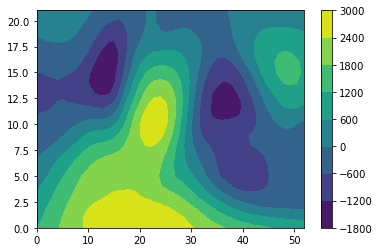

In [26]:
plt.contourf(ds_z500_anoms[variable][0,:,:])
plt.colorbar()

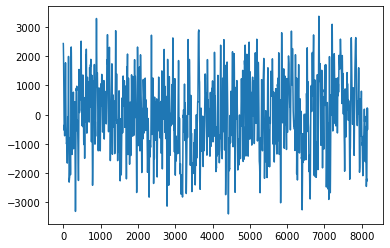

In [28]:
plt.plot(ds_z500_anoms[variable][:,12,25])

### Write to netcdf

In [51]:
#ds_z500_anoms.to_netcdf(outfile)

In [30]:
ds_z500_climo.to_netcdf(clim_out)